# Proyecto TRM - Analisis de Residual

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.layers import Input
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats
import numpy as np

# Configuración de estilo
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

In [65]:
from pathlib import Path

base = Path('.')
candidates = list(base.glob('**/Tasa*colombiano*.*'))
if not candidates:
    raise FileNotFoundError('No se encontró el archivo de tasa de cambio en el repositorio')
file_path = candidates[0]
print(f'Usando archivo: {file_path}')
if file_path.suffix.lower() in ('.xls', '.xlsx'):
    df = pd.read_excel(file_path)
else:
    df = pd.read_csv(file_path, encoding='latin1', sep=';')

Usando archivo: Tasa de cambio del peso colombiano .xlsx


In [66]:
df_clean = df.iloc[8857-730:8857]
df_clean = df_clean.reset_index(drop=True)
# df_clean = df.iloc[:8857]

In [67]:
# Seleccionamos las columnas y filas de interes para hacer los calculos con pandas
df_preprocessed = df_clean[['periodo', 'trm']]
df_preprocessed

# Se hace el calculo de primera y segunda diferencia
df_preprocessed['primera_dif'] = df_preprocessed['trm'].diff()
df_preprocessed['segunda_dif'] =df_preprocessed['trm'] - df_preprocessed['trm'].shift(2)

/tmp/ipykernel_10569/601938330.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preprocessed['primera_dif'] = df_preprocessed['trm'].diff()
/tmp/ipykernel_10569/601938330.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preprocessed['segunda_dif'] =df_preprocessed['trm'] - df_preprocessed['trm'].shift(2)


In [68]:
# Se calcula el valor minimo, maximo, promedio y desviacion estandar de la primera diferencia
min_diff = df_preprocessed['primera_dif'].min()
max_diff = df_preprocessed['primera_dif'].max()
mean_diff = df_preprocessed['primera_dif'].mean()
std_diff = df_preprocessed['primera_dif'].std()
min_trm = df_preprocessed['trm'].min()
max_trm = df_preprocessed['trm'].max()
min_diff, max_diff, mean_diff, std_diff

(np.float64(-154.6899999999996),
 np.float64(144.01999999999953),
 np.float64(-1.1582716049382724),
 np.float64(32.62069875697272))

In [69]:
df_preprocessed['trans_max_min_primera_dif'] = (df_preprocessed['primera_dif'] - min_diff) / (max_diff - min_diff)
df_preprocessed['estandarizacion'] = (df_preprocessed['primera_dif'] - mean_diff) / std_diff
# Normalización min-max de la columna trm
df_preprocessed['trans_max_min_trm'] = (df_preprocessed['trm'] - min_trm) / (max_trm - min_trm)
df_preprocessed['primera_dif_trans_max_min_trm'] = df_preprocessed['trans_max_min_trm'].diff()


/tmp/ipykernel_10569/241726627.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preprocessed['trans_max_min_primera_dif'] = (df_preprocessed['primera_dif'] - min_diff) / (max_diff - min_diff)
/tmp/ipykernel_10569/241726627.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preprocessed['estandarizacion'] = (df_preprocessed['primera_dif'] - mean_diff) / std_diff
/tmp/ipykernel_10569/241726627.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

In [70]:
# Se agregan lo rezagos
df_preprocessed['y_t'] = df_preprocessed['trm'].diff()
df_preprocessed['y_t-1'] = df_preprocessed['y_t'].shift(1)
df_preprocessed['y_t-2'] = df_preprocessed['y_t-1'].shift(1)
df_preprocessed['y_t-3'] = df_preprocessed['y_t-2'].shift(1)


/tmp/ipykernel_10569/98760068.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preprocessed['y_t'] = df_preprocessed['trm'].diff()
/tmp/ipykernel_10569/98760068.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preprocessed['y_t-1'] = df_preprocessed['y_t'].shift(1)
/tmp/ipykernel_10569/98760068.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

In [71]:
# Promedios moviles (ventana de 2 filas incluyendo la actual)
df_preprocessed['m_1'] = df_preprocessed['y_t'].rolling(window=2, min_periods=2).mean()
df_preprocessed['m_2'] = df_preprocessed['y_t'].rolling(window=3, min_periods=3).mean()
df_preprocessed['m_3'] = df_preprocessed['y_t'].rolling(window=4, min_periods=4).mean()

/tmp/ipykernel_10569/923652204.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preprocessed['m_1'] = df_preprocessed['y_t'].rolling(window=2, min_periods=2).mean()
/tmp/ipykernel_10569/923652204.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preprocessed['m_2'] = df_preprocessed['y_t'].rolling(window=3, min_periods=3).mean()
/tmp/ipykernel_10569/923652204.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [72]:
df_preprocessed

,periodo,trm,primera_dif,segunda_dif,trans_max_min_primera_dif,estandarizacion,trans_max_min_trm,primera_dif_trans_max_min_trm,y_t,y_t-1,y_t-2,y_t-3,m_1,m_2,m_3
0,2023-01-20,4683.85,NaN,NaN,NaN,NaN,0.765168,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-01-23,4631.64,-52.21,NaN,0.343075,-1.565010,0.721764,-0.043403,-52.21,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-01-24,4551.02,-80.62,-132.83,0.247966,-2.435930,0.654743,-0.067021,-80.62,-52.21,NaN,NaN,-66.415,NaN,NaN
3,2023-01-25,4545.94,-5.08,-85.70,0.500854,-0.120222,0.650520,-0.004223,-5.08,-80.62,-52.21,NaN,-42.850,-45.970000,NaN
4,2023-01-26,4538.91,-7.03,-12.11,0.494326,-0.180000,0.644675,-0.005844,-7.03,-5.08,-80.62,-52.21,-6.055,-30.910000,-36.2350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,2025-10-31,3870.42,-14.87,-4.42,0.468079,-0.420338,0.088943,-0.012362,-14.87,10.45,30.64,-14.43,-2.210,8.740000,2.9475
726,2025-11-03,3860.12,-10.30,-25.17,0.483379,-0.280243,0.080381,-0.008563,-10.30,-14.87,10.45,30.64,-12.585,-4.906667,3.9800
727,2025-11-04,3860.12,0.00,-10.30,0.517860,0.035507,0.080381,0.000000,0.00,-10.30,-14.87,10.45,-5.150,-8.390000,-3.6800
728,2025-11-05,3872.47,12.35,12.35,0.559205,0.414101,0.090648,0.010267,12.35,0.00,-10.30,-14.87,6.175,0.683333,-3.2050


## Análisis Exploratorio de Datos (EDA)

In [73]:
# Información general del dataset
print("=" * 60)
print("INFORMACIÓN GENERAL DEL DATASET")
print("=" * 60)
print(f"\nCantidad de registros: {len(df_preprocessed)}")
print(f"Cantidad de columnas: {len(df_preprocessed.columns)}")
print(f"\nColumnas: {list(df_preprocessed.columns)}")
print(f"\nRango de fechas: {df_preprocessed['periodo'].min()} a {df_preprocessed['periodo'].max()}")
print(f"\nValores nulos por columna:")
print(df_preprocessed.isnull().sum())

INFORMACIÓN GENERAL DEL DATASET

Cantidad de registros: 730
Cantidad de columnas: 15

Columnas: ['periodo', 'trm', 'primera_dif', 'segunda_dif', 'trans_max_min_primera_dif', 'estandarizacion', 'trans_max_min_trm', 'primera_dif_trans_max_min_trm', 'y_t', 'y_t-1', 'y_t-2', 'y_t-3', 'm_1', 'm_2', 'm_3']

Rango de fechas: 2023-01-20 00:00:00 a 2025-11-06 00:00:00

Valores nulos por columna:
periodo                          0
trm                              0
primera_dif                      1
segunda_dif                      2
trans_max_min_primera_dif        1
estandarizacion                  1
trans_max_min_trm                0
primera_dif_trans_max_min_trm    1
y_t                              1
y_t-1                            2
y_t-2                            3
y_t-3                            4
m_1                              2
m_2                              3
m_3                              4
dtype: int64


In [74]:
# Estadísticas descriptivas de las variables principales
print("\n" + "=" * 60)
print("ESTADÍSTICAS DESCRIPTIVAS - TRM")
print("=" * 60)
print(df_preprocessed['trm'].describe())

print("\n" + "=" * 60)
print("ESTADÍSTICAS DESCRIPTIVAS - PRIMERA DIFERENCIA")
print("=" * 60)
print(df_preprocessed['primera_dif'].describe())

print("\n" + "=" * 60)
print("ESTADÍSTICAS DESCRIPTIVAS - SEGUNDA DIFERENCIA")
print("=" * 60)
print(df_preprocessed['segunda_dif'].describe())


ESTADÍSTICAS DESCRIPTIVAS - TRM
count     730.000000
mean     4158.010452
std       248.679498
min      3763.430000
25%      3958.535000
50%      4111.450000
75%      4281.985000
max      4966.330000
Name: trm, dtype: float64

ESTADÍSTICAS DESCRIPTIVAS - PRIMERA DIFERENCIA
count    729.000000
mean      -1.158272
std       32.620699
min     -154.690000
25%      -20.890000
50%       -0.450000
75%       14.860000
max      144.020000
Name: primera_dif, dtype: float64

ESTADÍSTICAS DESCRIPTIVAS - SEGUNDA DIFERENCIA
count    728.000000
mean      -2.202679
std       49.832525
min     -174.160000
25%      -33.560000
50%       -5.355000
75%       23.827500
max      244.520000
Name: segunda_dif, dtype: float64


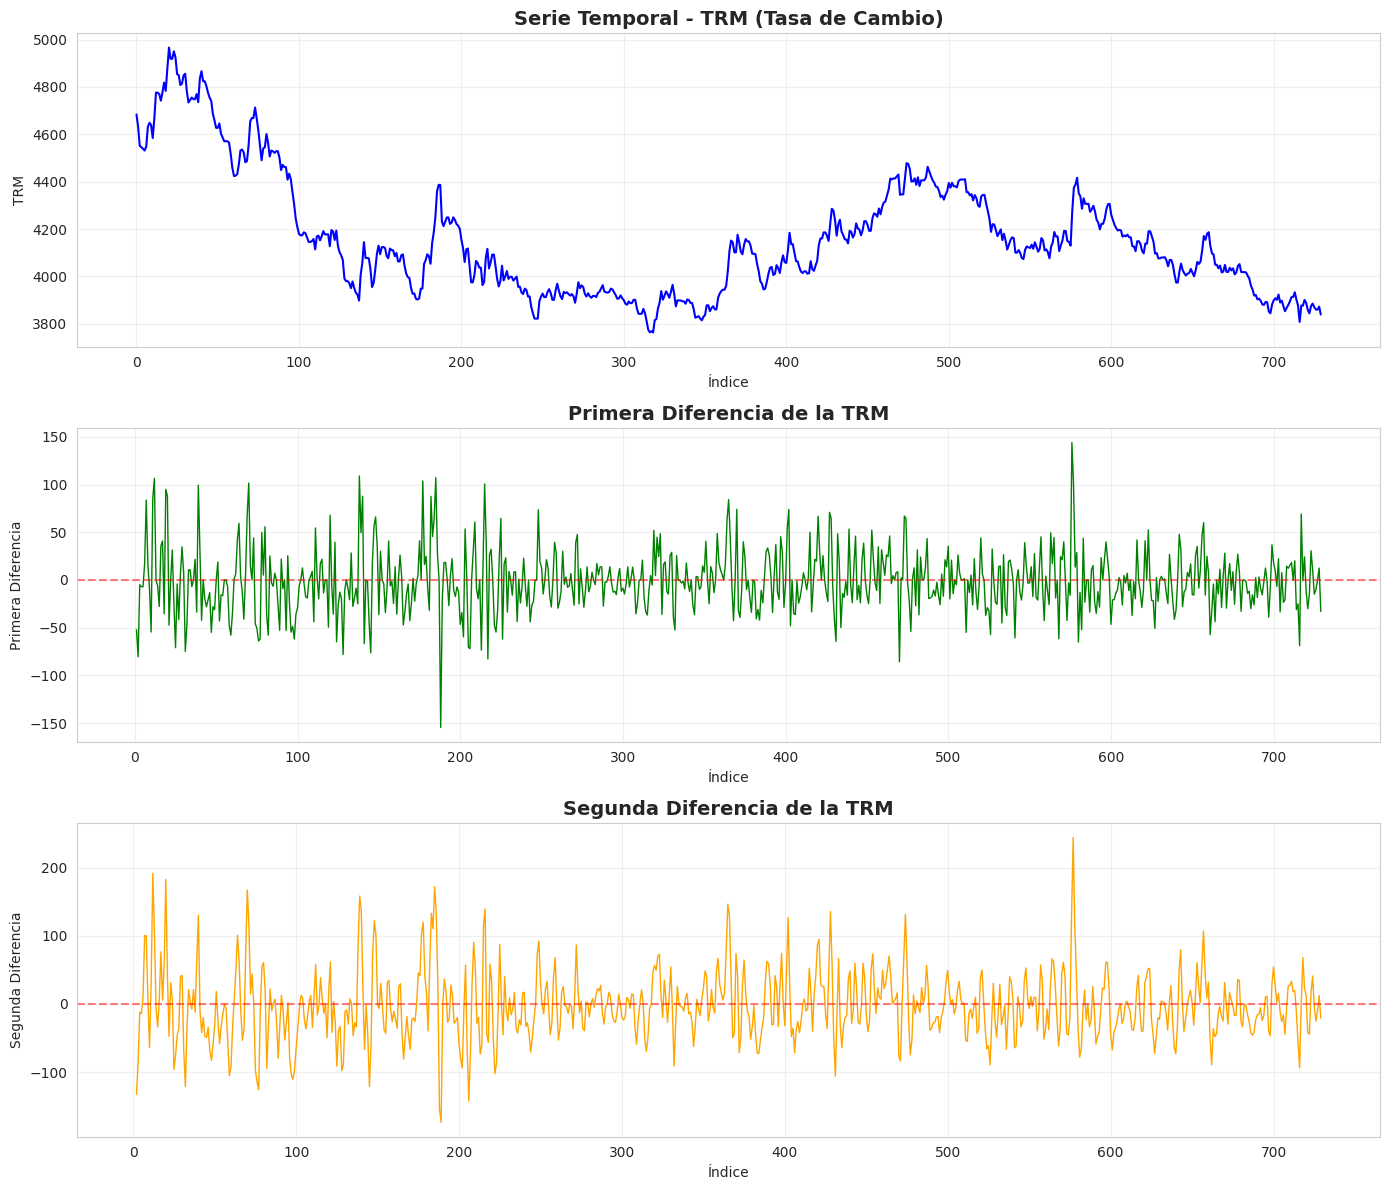

In [75]:
# Serie temporal de la TRM
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# TRM original
axes[0].plot(df_preprocessed.index, df_preprocessed['trm'], color='blue', linewidth=1.5)
axes[0].set_title('Serie Temporal - TRM (Tasa de Cambio)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Índice')
axes[0].set_ylabel('TRM')
axes[0].grid(True, alpha=0.3)

# Primera diferencia
axes[1].plot(df_preprocessed.index, df_preprocessed['primera_dif'], color='green', linewidth=1)
axes[1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[1].set_title('Primera Diferencia de la TRM', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Índice')
axes[1].set_ylabel('Primera Diferencia')
axes[1].grid(True, alpha=0.3)

# Segunda diferencia
axes[2].plot(df_preprocessed.index, df_preprocessed['segunda_dif'], color='orange', linewidth=1)
axes[2].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[2].set_title('Segunda Diferencia de la TRM', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Índice')
axes[2].set_ylabel('Segunda Diferencia')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

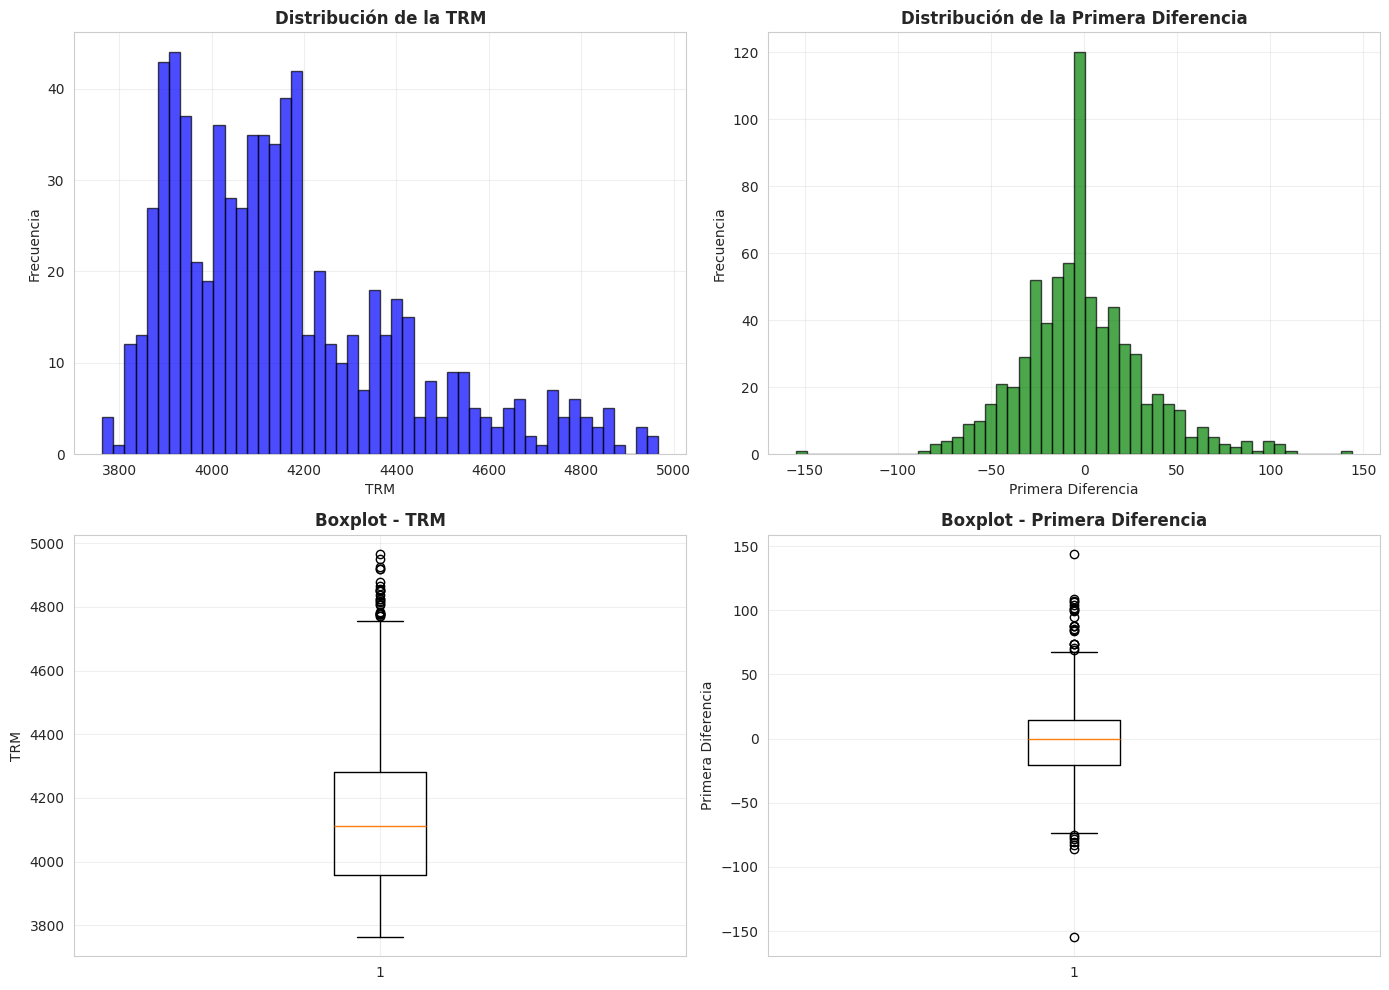

In [76]:
# Histogramas y distribuciones
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Histograma TRM
axes[0, 0].hist(df_preprocessed['trm'].dropna(), bins=50, color='blue', alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Distribución de la TRM', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('TRM')
axes[0, 0].set_ylabel('Frecuencia')
axes[0, 0].grid(True, alpha=0.3)

# Histograma primera diferencia
axes[0, 1].hist(df_preprocessed['primera_dif'].dropna(), bins=50, color='green', alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Distribución de la Primera Diferencia', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Primera Diferencia')
axes[0, 1].set_ylabel('Frecuencia')
axes[0, 1].grid(True, alpha=0.3)

# Boxplot TRM
axes[1, 0].boxplot(df_preprocessed['trm'].dropna(), vert=True)
axes[1, 0].set_title('Boxplot - TRM', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('TRM')
axes[1, 0].grid(True, alpha=0.3)

# Boxplot primera diferencia
axes[1, 1].boxplot(df_preprocessed['primera_dif'].dropna(), vert=True)
axes[1, 1].set_title('Boxplot - Primera Diferencia', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Primera Diferencia')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

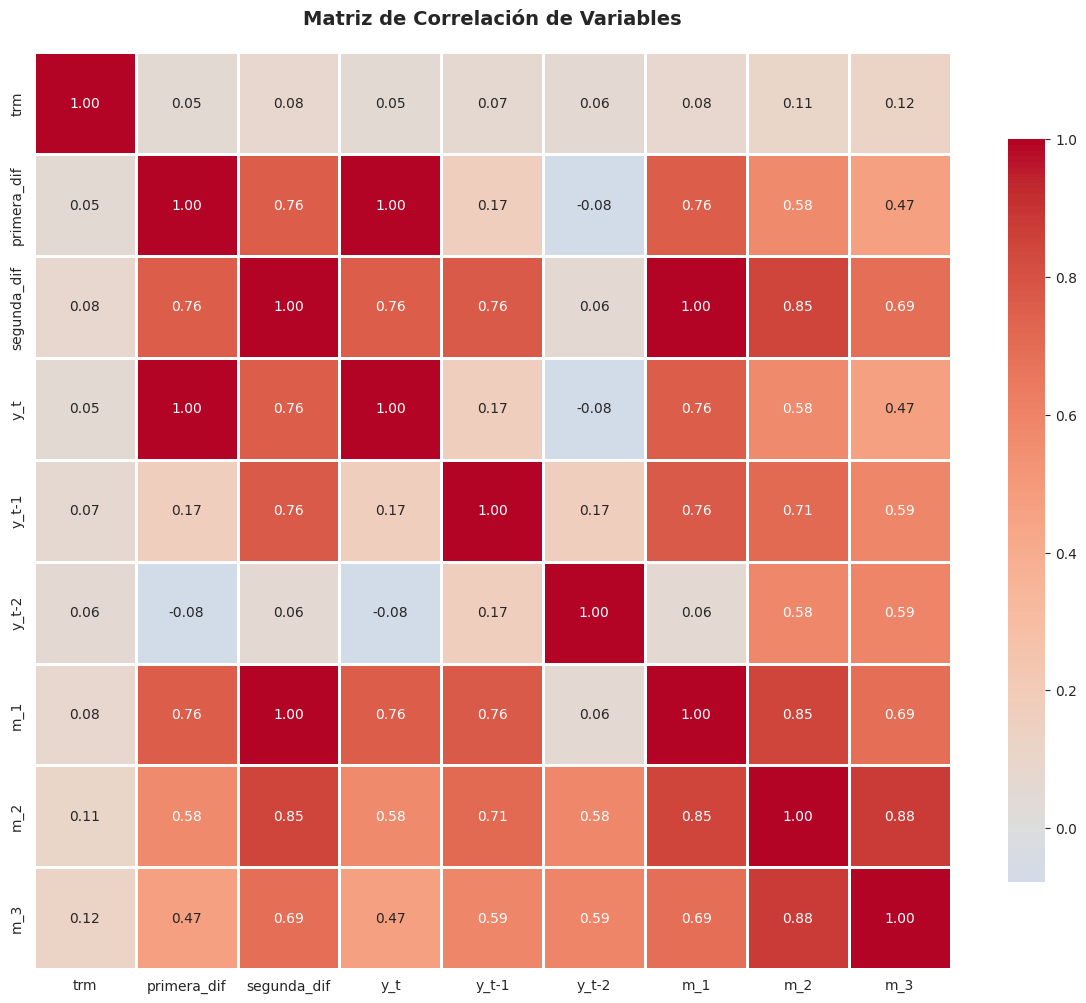

In [77]:
# Matriz de correlación
correlation_cols = ['trm', 'primera_dif', 'segunda_dif', 'y_t', 'y_t-1', 'y_t-2', 'm_1', 'm_2', 'm_3']
corr_matrix = df_preprocessed[correlation_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlación de Variables', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

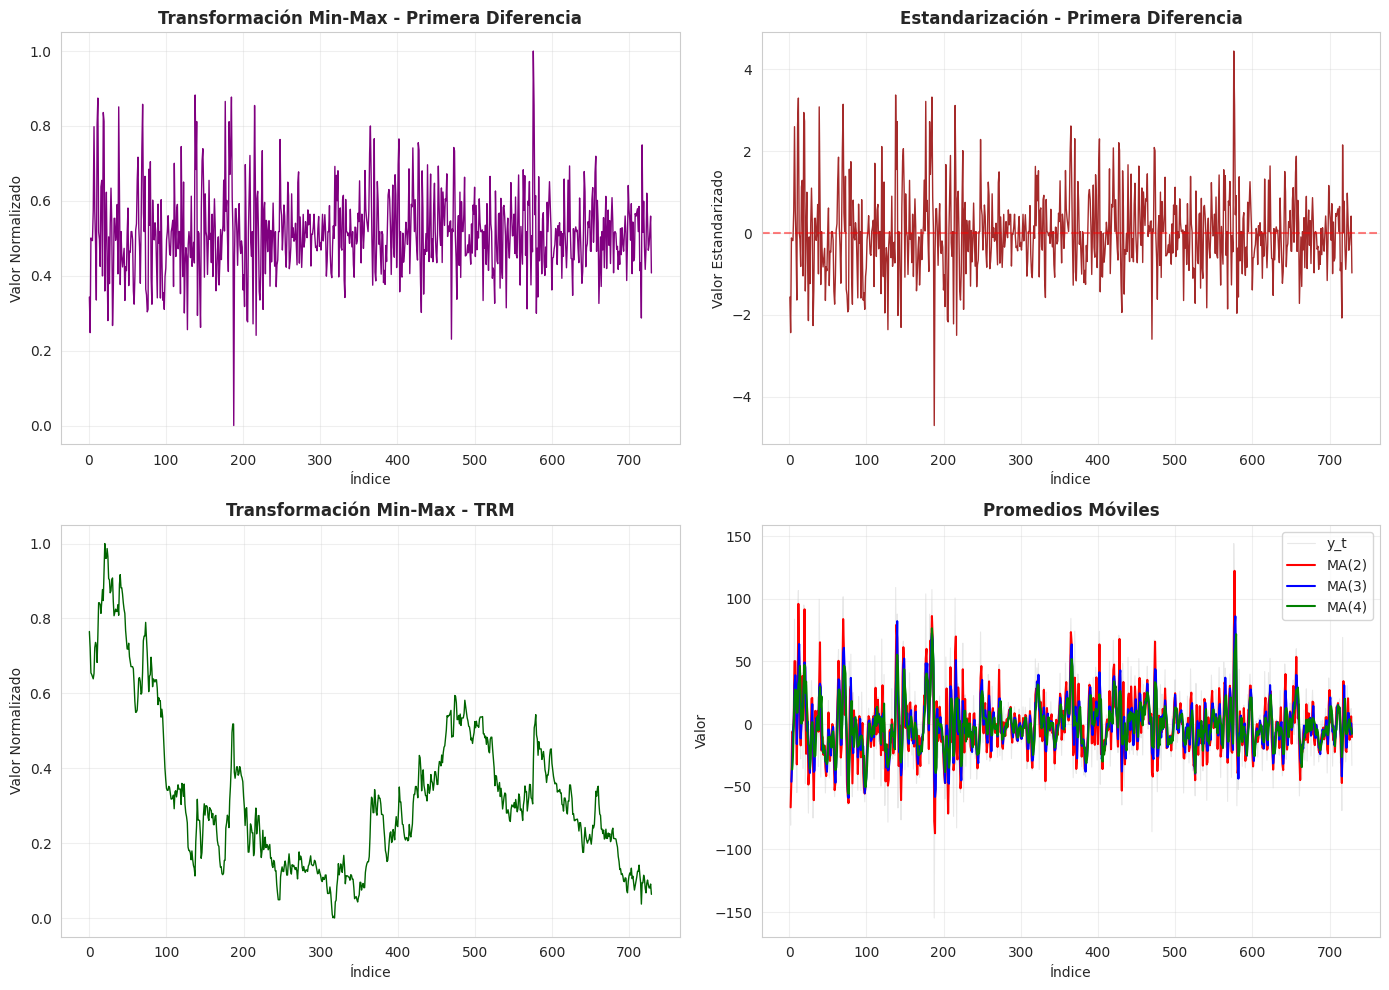

In [78]:
# Análisis de normalización y estandarización
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Transformación min-max de primera diferencia
axes[0, 0].plot(df_preprocessed.index, df_preprocessed['trans_max_min_primera_dif'], 
                color='purple', linewidth=1)
axes[0, 0].set_title('Transformación Min-Max - Primera Diferencia', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Índice')
axes[0, 0].set_ylabel('Valor Normalizado')
axes[0, 0].grid(True, alpha=0.3)

# Estandarización
axes[0, 1].plot(df_preprocessed.index, df_preprocessed['estandarizacion'], 
                color='brown', linewidth=1)
axes[0, 1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[0, 1].set_title('Estandarización - Primera Diferencia', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Índice')
axes[0, 1].set_ylabel('Valor Estandarizado')
axes[0, 1].grid(True, alpha=0.3)

# TRM normalizado
axes[1, 0].plot(df_preprocessed.index, df_preprocessed['trans_max_min_trm'], 
                color='darkgreen', linewidth=1)
axes[1, 0].set_title('Transformación Min-Max - TRM', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Índice')
axes[1, 0].set_ylabel('Valor Normalizado')
axes[1, 0].grid(True, alpha=0.3)

# Promedios móviles
axes[1, 1].plot(df_preprocessed.index, df_preprocessed['y_t'], 
                color='lightgray', linewidth=0.8, alpha=0.5, label='y_t')
axes[1, 1].plot(df_preprocessed.index, df_preprocessed['m_1'], 
                color='red', linewidth=1.5, label='MA(2)')
axes[1, 1].plot(df_preprocessed.index, df_preprocessed['m_2'], 
                color='blue', linewidth=1.5, label='MA(3)')
axes[1, 1].plot(df_preprocessed.index, df_preprocessed['m_3'], 
                color='green', linewidth=1.5, label='MA(4)')
axes[1, 1].set_title('Promedios Móviles', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Índice')
axes[1, 1].set_ylabel('Valor')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [79]:
# Resumen estadístico final
print("\n" + "=" * 60)
print("RESUMEN DEL ANÁLISIS EXPLORATORIO")
print("=" * 60)

print("\n1. CARACTERÍSTICAS DEL DATASET:")
print(f"   - Total de observaciones: {len(df_preprocessed)}")
print(f"   - Periodo analizado: {df_preprocessed['periodo'].min()} a {df_preprocessed['periodo'].max()}")
print(f"   - Variables generadas: {len(df_preprocessed.columns)}")

print("\n2. TRM (TASA DE CAMBIO):")
print(f"   - Promedio: {df_preprocessed['trm'].mean():.2f}")
print(f"   - Mediana: {df_preprocessed['trm'].median():.2f}")
print(f"   - Mínimo: {df_preprocessed['trm'].min():.2f}")
print(f"   - Máximo: {df_preprocessed['trm'].max():.2f}")
print(f"   - Desviación Estándar: {df_preprocessed['trm'].std():.2f}")

print("\n3. PRIMERA DIFERENCIA:")
print(f"   - Promedio: {df_preprocessed['primera_dif'].mean():.2f}")
print(f"   - Mediana: {df_preprocessed['primera_dif'].median():.2f}")
print(f"   - Rango: [{df_preprocessed['primera_dif'].min():.2f}, {df_preprocessed['primera_dif'].max():.2f}]")
print(f"   - Desviación Estándar: {df_preprocessed['primera_dif'].std():.2f}")

print("\n4. VALORES NULOS:")
print(f"   - Total de valores nulos: {df_preprocessed.isnull().sum().sum()}")
print(f"   - Porcentaje de completitud: {((1 - df_preprocessed.isnull().sum().sum() / (len(df_preprocessed) * len(df_preprocessed.columns))) * 100):.2f}%")

print("\n" + "=" * 60)


RESUMEN DEL ANÁLISIS EXPLORATORIO

1. CARACTERÍSTICAS DEL DATASET:
   - Total de observaciones: 730
   - Periodo analizado: 2023-01-20 00:00:00 a 2025-11-06 00:00:00
   - Variables generadas: 15

2. TRM (TASA DE CAMBIO):
   - Promedio: 4158.01
   - Mediana: 4111.45
   - Mínimo: 3763.43
   - Máximo: 4966.33
   - Desviación Estándar: 248.68

3. PRIMERA DIFERENCIA:
   - Promedio: -1.16
   - Mediana: -0.45
   - Rango: [-154.69, 144.02]
   - Desviación Estándar: 32.62

4. VALORES NULOS:
   - Total de valores nulos: 25
   - Porcentaje de completitud: 99.77%



## Análisis de Residual (Ejercicio hecho en clase)

In [80]:
## Limpieza de nulos
df_preprocessed.dropna(inplace=True)
print(df_clean.isnull().sum())

periodo              0
trm                  0
dia                  0
primera_dif          0
segunda_dif          0
trans_max_min        0
estanrazicacion z    0
trans_max_min.1      0
1dif                 0
y_t                  0
y_t-1                0
y_t-2                0
y_t-3                0
m1                   0
m2                   0
m3                   0
m4                   0
m5                   0
dtype: int64


/tmp/ipykernel_10569/4123291156.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preprocessed.dropna(inplace=True)


In [81]:
df_preprocessed

,periodo,trm,primera_dif,segunda_dif,trans_max_min_primera_dif,estandarizacion,trans_max_min_trm,primera_dif_trans_max_min_trm,y_t,y_t-1,y_t-2,y_t-3,m_1,m_2,m_3
4,2023-01-26,4538.91,-7.03,-12.11,0.494326,-0.180000,0.644675,-0.005844,-7.03,-5.08,-80.62,-52.21,-6.055,-30.910000,-36.2350
5,2023-01-27,4531.75,-7.16,-14.19,0.493890,-0.183985,0.638723,-0.005952,-7.16,-7.03,-5.08,-80.62,-7.095,-6.423333,-24.9725
6,2023-01-30,4548.50,16.75,9.59,0.573935,0.548985,0.652648,0.013925,16.75,-7.16,-7.03,-5.08,4.795,0.853333,-0.6300
7,2023-01-31,4632.20,83.70,100.45,0.798065,2.601363,0.722230,0.069582,83.70,16.75,-7.16,-7.03,50.225,31.096667,21.5650
8,2023-02-01,4648.70,16.50,100.20,0.573098,0.541321,0.735946,0.013717,16.50,83.70,16.75,-7.16,50.100,38.983333,27.4475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,2025-10-31,3870.42,-14.87,-4.42,0.468079,-0.420338,0.088943,-0.012362,-14.87,10.45,30.64,-14.43,-2.210,8.740000,2.9475
726,2025-11-03,3860.12,-10.30,-25.17,0.483379,-0.280243,0.080381,-0.008563,-10.30,-14.87,10.45,30.64,-12.585,-4.906667,3.9800
727,2025-11-04,3860.12,0.00,-10.30,0.517860,0.035507,0.080381,0.000000,0.00,-10.30,-14.87,10.45,-5.150,-8.390000,-3.6800
728,2025-11-05,3872.47,12.35,12.35,0.559205,0.414101,0.090648,0.010267,12.35,0.00,-10.30,-14.87,6.175,0.683333,-3.2050


In [82]:
# Extraccion de columnas de interes para el entrenamiento
y = df_preprocessed['y_t']
X = df_preprocessed[['y_t-1', 'y_t-2', 'y_t-3', 'm_1', 'm_2', 'm_3']]

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")
display(X.head())
display(y.head())

Shape of X: (726, 6)
Shape of y: (726,)


,y_t-1,y_t-2,y_t-3,m_1,m_2,m_3
4,-5.08,-80.62,-52.21,-6.055,-30.910000,-36.2350
5,-7.03,-5.08,-80.62,-7.095,-6.423333,-24.9725
6,-7.16,-7.03,-5.08,4.795,0.853333,-0.6300
7,16.75,-7.16,-7.03,50.225,31.096667,21.5650
8,83.70,16.75,-7.16,50.100,38.983333,27.4475


4    -7.03
5    -7.16
6    16.75
7    83.70
8    16.50
Name: y_t, dtype: float64

In [83]:
from keras.layers import Input

model = Sequential()
model.add(Input(shape=(X.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,201 (12.50 KB)

 Trainable params: 3,201 (12.50 KB)

 Non-trainable params: 0 (0.00 B)

In [84]:
history = model.fit(X, y, epochs=200, validation_data=(X, y), verbose=1)
print("Model training complete. History stored.")

Epoch 1/200
 1/23 ━━━━━━━━━━━━━━━━━━━━ 20s 951ms/step - loss: 1212.0826 - mean_absolute_error: 24.3761

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 921.1779 - mean_absolute_error: 21.8858 - val_loss: 793.7919 - val_mean_absolute_error: 20.1563
Epoch 2/200
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 676.7338 - mean_absolute_error: 18.1125 - val_loss: 503.5177 - val_mean_absolute_error: 14.9488
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 676.7338 - mean_absolute_error: 18.1125 - val_loss: 503.5177 - val_mean_absolute_error: 14.9488
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 314.3859 - mean_absolute_error: 11.3021 - val_loss: 155.8863 - val_mean_absolute_error: 7.7460
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 314.3859 - mean_absolute_error: 11.3021 - val_loss: 155.8863 - val_mean_absolute_error: 7.7460
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 103.6530 - mean_absolute_error: 6.6361 - val_loss: 55.0604 - val_mean_absolute_error: 4.8930
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 103.6530 - mean_

In [85]:
y_pred = model.predict(X)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [86]:
eval_results = model.evaluate(X, y, verbose=0)
print(f"Model Evaluation - MSE: {eval_results[0]:.2f}, MAE: {eval_results[1]:.2f}")

residuals = y - y_pred.flatten()
print("Residuals calculated.")

Model Evaluation - MSE: 0.11, MAE: 0.26
Residuals calculated.


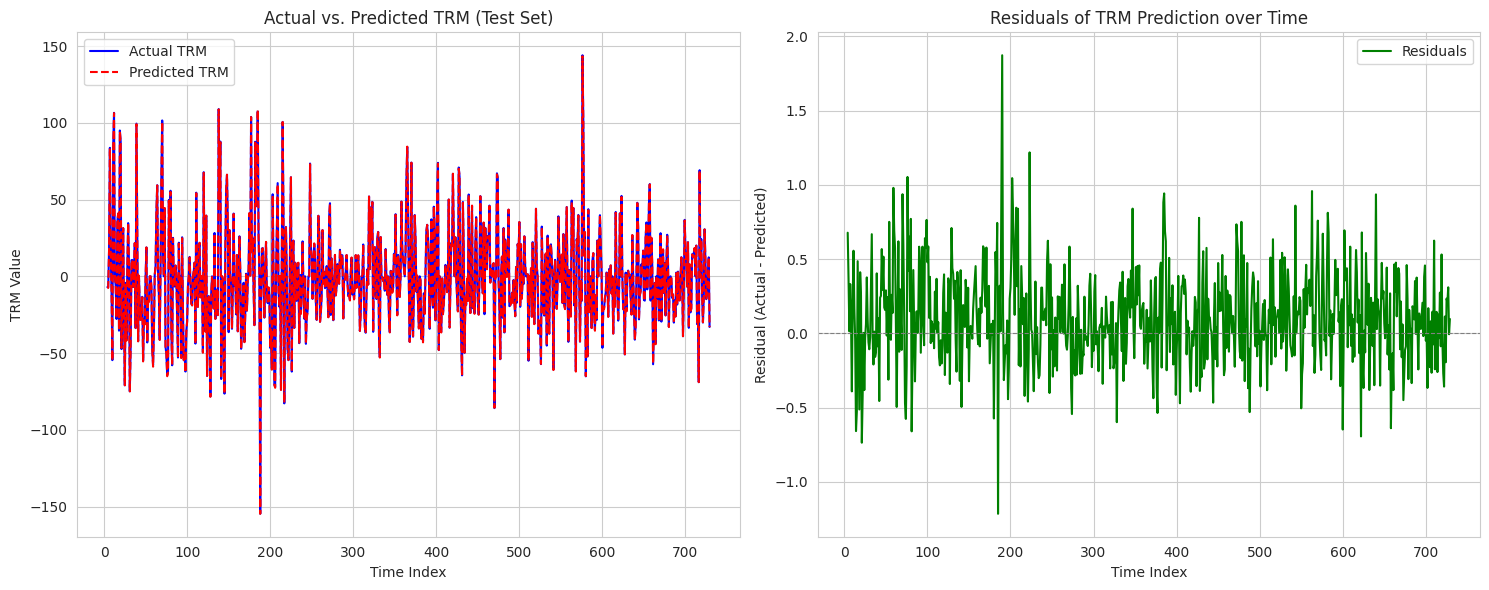

In [87]:
plt.figure(figsize=(15, 6))

# Plot 1: Actual vs. Predicted TRM values
plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
plt.plot(y.index, y, label='Actual TRM', color='blue')
plt.plot(y.index, y_pred.flatten(), label='Predicted TRM', color='red', linestyle='--')
plt.title('Actual vs. Predicted TRM (Test Set)')
plt.xlabel('Time Index')
plt.ylabel('TRM Value')
plt.legend()
plt.grid(True)

# Plot 2: Residuals over time
plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
plt.plot(y.index, residuals, label='Residuals', color='green')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
plt.title('Residuals of TRM Prediction over Time')
plt.xlabel('Time Index')
plt.ylabel('Residual (Actual - Predicted)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Análisis de Propiedades de los Residuales

A continuación se analizan las propiedades estadísticas de los residuales para validar la calidad del modelo según los criterios vistos en clase:

1. **Valor esperado cero**: El promedio de los residuales debe ser cercano a 0
2. **No autocorrelación**: Los residuales no deben mostrar correlación entre sí a lo largo del tiempo
3. **Aleatoriedad e independencia**: Los residuales deben ser variables aleatorias independientes
4. **Comportamiento como ruido blanco**: Media cercana a 0 y varianza constante (homocedasticidad)

### 1. Propiedades Básicas de los Residuales

In [88]:
# 1. VERIFICACIÓN DE VALOR ESPERADO CERO
print("=" * 70)
print("1. ANÁLISIS DE VALOR ESPERADO (MEDIA) DE LOS RESIDUALES")
print("=" * 70)

mean_residuals = residuals.mean()
std_residuals = residuals.std()
variance_residuals = residuals.var()

print(f"\nMedia de los residuales: {mean_residuals:.6f}")
print(f"Desviación estándar: {std_residuals:.6f}")
print(f"Varianza: {variance_residuals:.6f}")

# Criterio: La media debe ser cercana a 0
if abs(mean_residuals) < 0.01:
    print(f"\n✓ CUMPLE: La media está muy cercana a 0 (|{mean_residuals:.6f}| < 0.01)")
elif abs(mean_residuals) < 0.1:
    print(f"\n⚠ ACEPTABLE: La media está relativamente cerca de 0 (|{mean_residuals:.6f}| < 0.1)")
else:
    print(f"\n✗ NO CUMPLE: La media se aleja de 0 (|{mean_residuals:.6f}| >= 0.1)")

print("\n" + "=" * 70)

1. ANÁLISIS DE VALOR ESPERADO (MEDIA) DE LOS RESIDUALES

Media de los residuales: 0.106673
Desviación estándar: 0.317700
Varianza: 0.100933

✗ NO CUMPLE: La media se aleja de 0 (|0.106673| >= 0.1)



### 2. Test de Autocorrelación de los Residuales

In [89]:
# 2. TEST DE AUTOCORRELACIÓN DE REZAGOS
# Recomendación: tomar hasta 15 días de rezago o 3 semanas
# Correlación >0.3 o <-0.3 es muy alta

print("=" * 70)
print("2. TEST DE AUTOCORRELACIÓN DE REZAGOS")
print("=" * 70)
print("\nCriterio: Correlación entre -0.3 y 0.3 es aceptable")
print("Rezagos analizados: hasta 15 días\n")

# Calcular autocorrelación para diferentes lags
max_lag = min(15, len(residuals) - 1)
autocorr_values = []

for lag in range(1, max_lag + 1):
    # Correlación entre residual_t y residual_{t-lag}
    corr = residuals.iloc[lag:].corr(residuals.iloc[:-lag])
    autocorr_values.append(corr)
    
    status = "✓" if abs(corr) < 0.3 else "✗"
    print(f"Lag {lag:2d}: Autocorrelación = {corr:7.4f} {status}")

# Resumen
problematic_lags = sum(1 for corr in autocorr_values if abs(corr) >= 0.3)
print(f"\nResumen: {problematic_lags}/{max_lag} lags con autocorrelación problemática (|corr| >= 0.3)")

if problematic_lags == 0:
    print("✓ CUMPLE: No hay autocorrelación significativa")
elif problematic_lags <= max_lag * 0.2:
    print("⚠ ACEPTABLE: Baja autocorrelación detectada")
else:
    print("✗ NO CUMPLE: Alta autocorrelación detectada - el modelo no captura toda la estructura")

print("=" * 70)

2. TEST DE AUTOCORRELACIÓN DE REZAGOS

Criterio: Correlación entre -0.3 y 0.3 es aceptable
Rezagos analizados: hasta 15 días

Lag  1: Autocorrelación =  1.0000 ✗
Lag  2: Autocorrelación =  1.0000 ✗
Lag  3: Autocorrelación =  1.0000 ✗
Lag  4: Autocorrelación =  1.0000 ✗
Lag  5: Autocorrelación =  1.0000 ✗
Lag  6: Autocorrelación =  1.0000 ✗
Lag  7: Autocorrelación =  1.0000 ✗
Lag  8: Autocorrelación =  1.0000 ✗
Lag  9: Autocorrelación =  1.0000 ✗
Lag 10: Autocorrelación =  1.0000 ✗
Lag 11: Autocorrelación =  1.0000 ✗
Lag 12: Autocorrelación =  1.0000 ✗
Lag 13: Autocorrelación =  1.0000 ✗
Lag 14: Autocorrelación =  1.0000 ✗
Lag 15: Autocorrelación =  1.0000 ✗

Resumen: 15/15 lags con autocorrelación problemática (|corr| >= 0.3)
✗ NO CUMPLE: Alta autocorrelación detectada - el modelo no captura toda la estructura


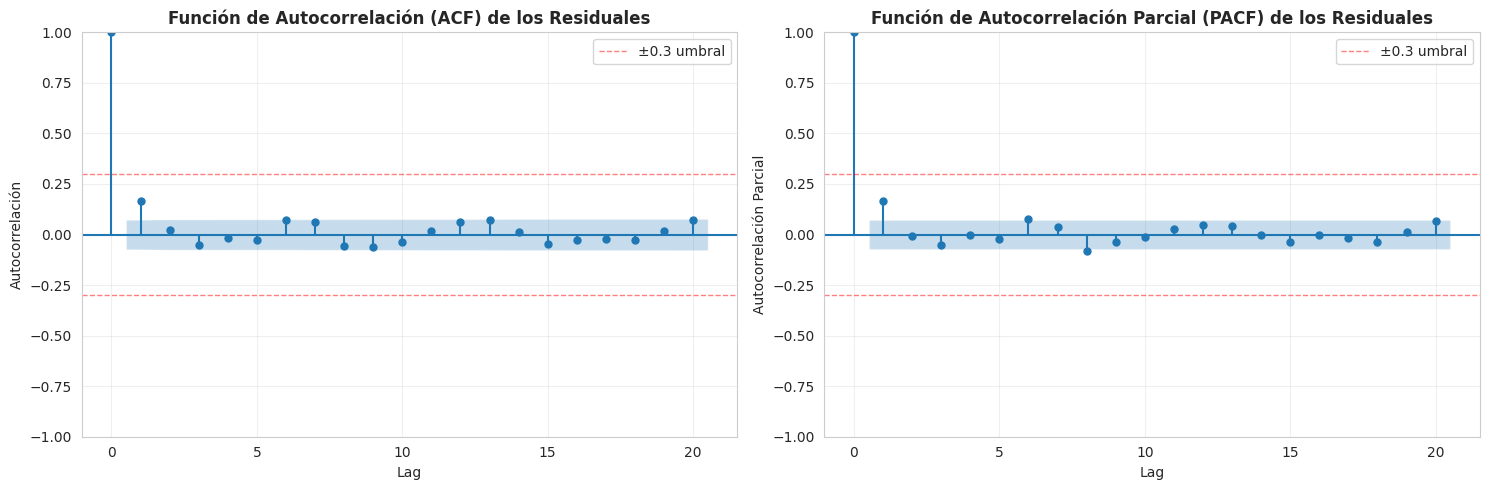

In [90]:
# Gráfico de autocorrelación

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# ACF Plot
plot_acf(residuals, lags=min(20, len(residuals) - 1), ax=axes[0], alpha=0.05)
axes[0].set_title('Función de Autocorrelación (ACF) de los Residuales', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('Autocorrelación')
axes[0].axhline(y=0.3, color='red', linestyle='--', linewidth=1, alpha=0.5, label='±0.3 umbral')
axes[0].axhline(y=-0.3, color='red', linestyle='--', linewidth=1, alpha=0.5)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# PACF Plot
plot_pacf(residuals, lags=min(20, len(residuals) - 1), ax=axes[1], alpha=0.05)
axes[1].set_title('Función de Autocorrelación Parcial (PACF) de los Residuales', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('Autocorrelación Parcial')
axes[1].axhline(y=0.3, color='red', linestyle='--', linewidth=1, alpha=0.5, label='±0.3 umbral')
axes[1].axhline(y=-0.3, color='red', linestyle='--', linewidth=1, alpha=0.5)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [91]:
# Correlación entre residuales y variables explicativas (Y_t y X)
print("=" * 70)
print("2.1. CORRELACIÓN ENTRE RESIDUALES Y VARIABLES")
print("=" * 70)

# Correlación entre residuales y Y_t
corr_res_yt = residuals.corr(y)
print(f"\nCorrelación entre residuales y Y_t: {corr_res_yt:.4f}")

# Correlación entre residuales y cada variable explicativa
print("\nCorrelación entre residuales y variables explicativas:")
for col in X.columns:
    corr = residuals.corr(X[col])
    status = "✓" if abs(corr) < 0.3 else "✗"
    print(f"  {col:8s}: {corr:7.4f} {status}")

# Verificar independencia
high_corr_count = sum(1 for col in X.columns if abs(residuals.corr(X[col])) >= 0.3)

if abs(corr_res_yt) < 0.3 and high_corr_count == 0:
    print("\n✓ CUMPLE: Los residuales son independientes de Y_t y X")
else:
    print("\n✗ NO CUMPLE: Existe dependencia entre residuales y las variables")

print("=" * 70)

2.1. CORRELACIÓN ENTRE RESIDUALES Y VARIABLES

Correlación entre residuales y Y_t: 0.0957

Correlación entre residuales y variables explicativas:
  y_t-1   : -0.2952 ✓
  y_t-2   : -0.3210 ✗
  y_t-3   : -0.2198 ✓
  m_1     : -0.1307 ✓
  m_2     : -0.2786 ✓
  m_3     : -0.3499 ✗

✗ NO CUMPLE: Existe dependencia entre residuales y las variables


### 3. Test de Normalidad de los Residuales

In [92]:
# 3. TEST DE NORMALIDAD
# Shapiro-Wilk y Kolmogorov-Smirnov
# P > 0.05 para que el test sea válido (no rechazamos H0: los datos son normales)


print("=" * 70)
print("3. TEST DE NORMALIDAD DE LOS RESIDUALES")
print("=" * 70)
print("\nCriterio: P-value > 0.05 indica normalidad (no se rechaza H0)")

# Test de Shapiro-Wilk
shapiro_stat, shapiro_p = stats.shapiro(residuals)
print(f"\n--- Test de Shapiro-Wilk ---")
print(f"Estadístico: {shapiro_stat:.6f}")
print(f"P-value: {shapiro_p:.6f}")

if shapiro_p > 0.05:
    print(f"✓ CUMPLE: Los residuales siguen una distribución normal (p={shapiro_p:.4f} > 0.05)")
else:
    print(f"✗ NO CUMPLE: Los residuales NO siguen una distribución normal (p={shapiro_p:.4f} <= 0.05)")

# Test de Kolmogorov-Smirnov
ks_stat, ks_p = stats.kstest(residuals, 'norm', args=(residuals.mean(), residuals.std()))
print(f"\n--- Test de Kolmogorov-Smirnov ---")
print(f"Estadístico: {ks_stat:.6f}")
print(f"P-value: {ks_p:.6f}")

if ks_p > 0.05:
    print(f"✓ CUMPLE: Los residuales siguen una distribución normal (p={ks_p:.4f} > 0.05)")
else:
    print(f"✗ NO CUMPLE: Los residuales NO siguen una distribución normal (p={ks_p:.4f} <= 0.05)")

print("\nNOTA: Es común que la normalidad sea difícil de lograr completamente.")
print("Lo importante es que se cumplan las propiedades 1, 2 y 4.")
print("=" * 70)

3. TEST DE NORMALIDAD DE LOS RESIDUALES

Criterio: P-value > 0.05 indica normalidad (no se rechaza H0)

--- Test de Shapiro-Wilk ---
Estadístico: 0.986305
P-value: 0.000003
✗ NO CUMPLE: Los residuales NO siguen una distribución normal (p=0.0000 <= 0.05)

--- Test de Kolmogorov-Smirnov ---
Estadístico: 0.035464
P-value: 0.313323
✓ CUMPLE: Los residuales siguen una distribución normal (p=0.3133 > 0.05)

NOTA: Es común que la normalidad sea difícil de lograr completamente.
Lo importante es que se cumplan las propiedades 1, 2 y 4.


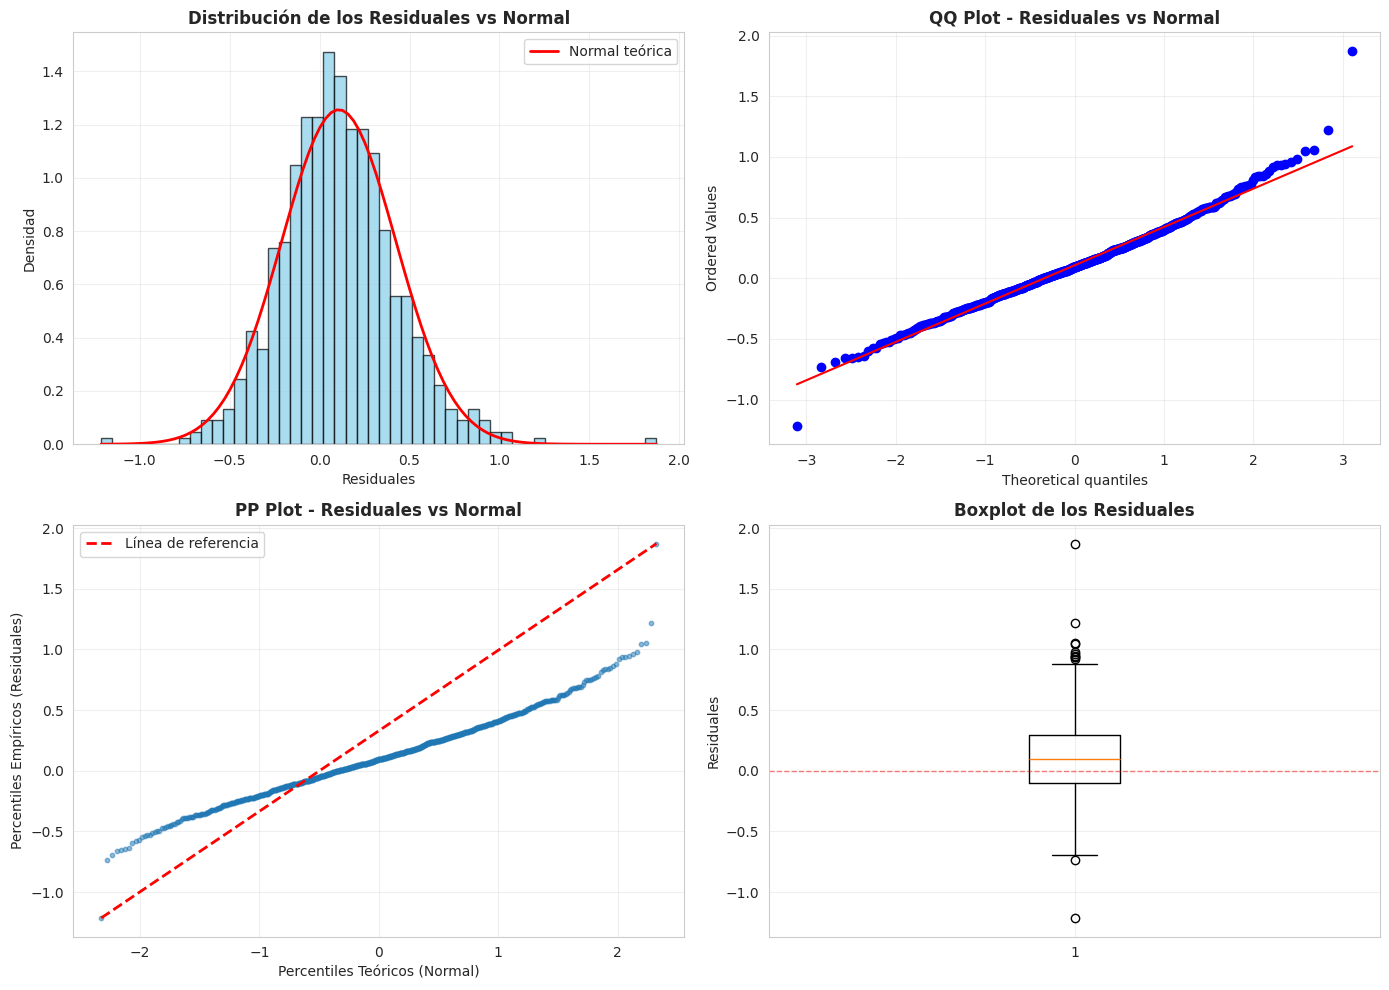

In [93]:
# Gráficos de normalidad: QQ Plot y PP Plot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Histograma de residuales con curva normal
axes[0, 0].hist(residuals, bins=50, density=True, alpha=0.7, color='skyblue', edgecolor='black')
mu, sigma = residuals.mean(), residuals.std()
x = np.linspace(residuals.min(), residuals.max(), 100)
axes[0, 0].plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label='Normal teórica')
axes[0, 0].set_title('Distribución de los Residuales vs Normal', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Residuales')
axes[0, 0].set_ylabel('Densidad')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# QQ Plot
stats.probplot(residuals, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('QQ Plot - Residuales vs Normal', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# PP Plot (Probability Plot)
# Calculamos los percentiles empíricos y teóricos
sorted_residuals = np.sort(residuals)
norm_quantiles = stats.norm.ppf(np.linspace(0.01, 0.99, len(sorted_residuals)))
axes[1, 0].scatter(norm_quantiles, sorted_residuals, alpha=0.5, s=10)
axes[1, 0].plot([norm_quantiles.min(), norm_quantiles.max()], 
                 [sorted_residuals.min(), sorted_residuals.max()], 
                 'r--', linewidth=2, label='Línea de referencia')
axes[1, 0].set_title('PP Plot - Residuales vs Normal', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Percentiles Teóricos (Normal)')
axes[1, 0].set_ylabel('Percentiles Empíricos (Residuales)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Boxplot de residuales
axes[1, 1].boxplot(residuals, vert=True)
axes[1, 1].set_title('Boxplot de los Residuales', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Residuales')
axes[1, 1].axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 4. Test ARCH para Homocedasticidad

In [94]:
# 4. TEST ARCH PARA HOMOCEDASTICIDAD
# Es una regresión sobre la varianza - si puedo predecir la varianza hay heterocedasticidad
# H0: No existe heterocedasticidad (responde 0)
# Ha: Existe heterocedasticidad en el Lag de k (responde 1)

from statsmodels.stats.diagnostic import het_arch

print("=" * 70)
print("4. TEST ARCH PARA HOMOCEDASTICIDAD")
print("=" * 70)
print("\nH0: No existe heterocedasticidad (varianza constante)")
print("Ha: Existe heterocedasticidad (varianza NO constante)")
print("Criterio: P-value > 0.05 indica homocedasticidad (no se rechaza H0)\n")

# Test ARCH con diferentes lags
lags_to_test = [1, 3, 5, 10]

for lag in lags_to_test:
    try:
        lm_stat, lm_pvalue, f_stat, f_pvalue = het_arch(residuals, nlags=lag)
        
        print(f"--- Test ARCH (Lag = {lag}) ---")
        print(f"LM Statistic: {lm_stat:.6f}")
        print(f"LM P-value: {lm_pvalue:.6f}")
        print(f"F-statistic: {f_stat:.6f}")
        print(f"F P-value: {f_pvalue:.6f}")
        
        if lm_pvalue > 0.05:
            print(f"✓ CUMPLE: No hay heterocedasticidad para lag {lag} (p={lm_pvalue:.4f} > 0.05)")
        else:
            print(f"✗ NO CUMPLE: Existe heterocedasticidad para lag {lag} (p={lm_pvalue:.4f} <= 0.05)")
        print()
    except Exception as e:
        print(f"Error en lag {lag}: {e}\n")

print("=" * 70)

4. TEST ARCH PARA HOMOCEDASTICIDAD

H0: No existe heterocedasticidad (varianza constante)
Ha: Existe heterocedasticidad (varianza NO constante)
Criterio: P-value > 0.05 indica homocedasticidad (no se rechaza H0)

--- Test ARCH (Lag = 1) ---
LM Statistic: 21.393177
LM P-value: 0.000004
F-statistic: 21.982827
F P-value: 0.000003
✗ NO CUMPLE: Existe heterocedasticidad para lag 1 (p=0.0000 <= 0.05)

--- Test ARCH (Lag = 3) ---
LM Statistic: 21.495283
LM P-value: 0.000083
F-statistic: 7.343789
F P-value: 0.000075
✗ NO CUMPLE: Existe heterocedasticidad para lag 3 (p=0.0001 <= 0.05)

--- Test ARCH (Lag = 5) ---
LM Statistic: 47.695022
LM P-value: 0.000000
F-statistic: 10.129716
F P-value: 0.000000
✗ NO CUMPLE: Existe heterocedasticidad para lag 5 (p=0.0000 <= 0.05)

--- Test ARCH (Lag = 10) ---
LM Statistic: 50.340839
LM P-value: 0.000000
F-statistic: 5.331601
F P-value: 0.000000
✗ NO CUMPLE: Existe heterocedasticidad para lag 10 (p=0.0000 <= 0.05)



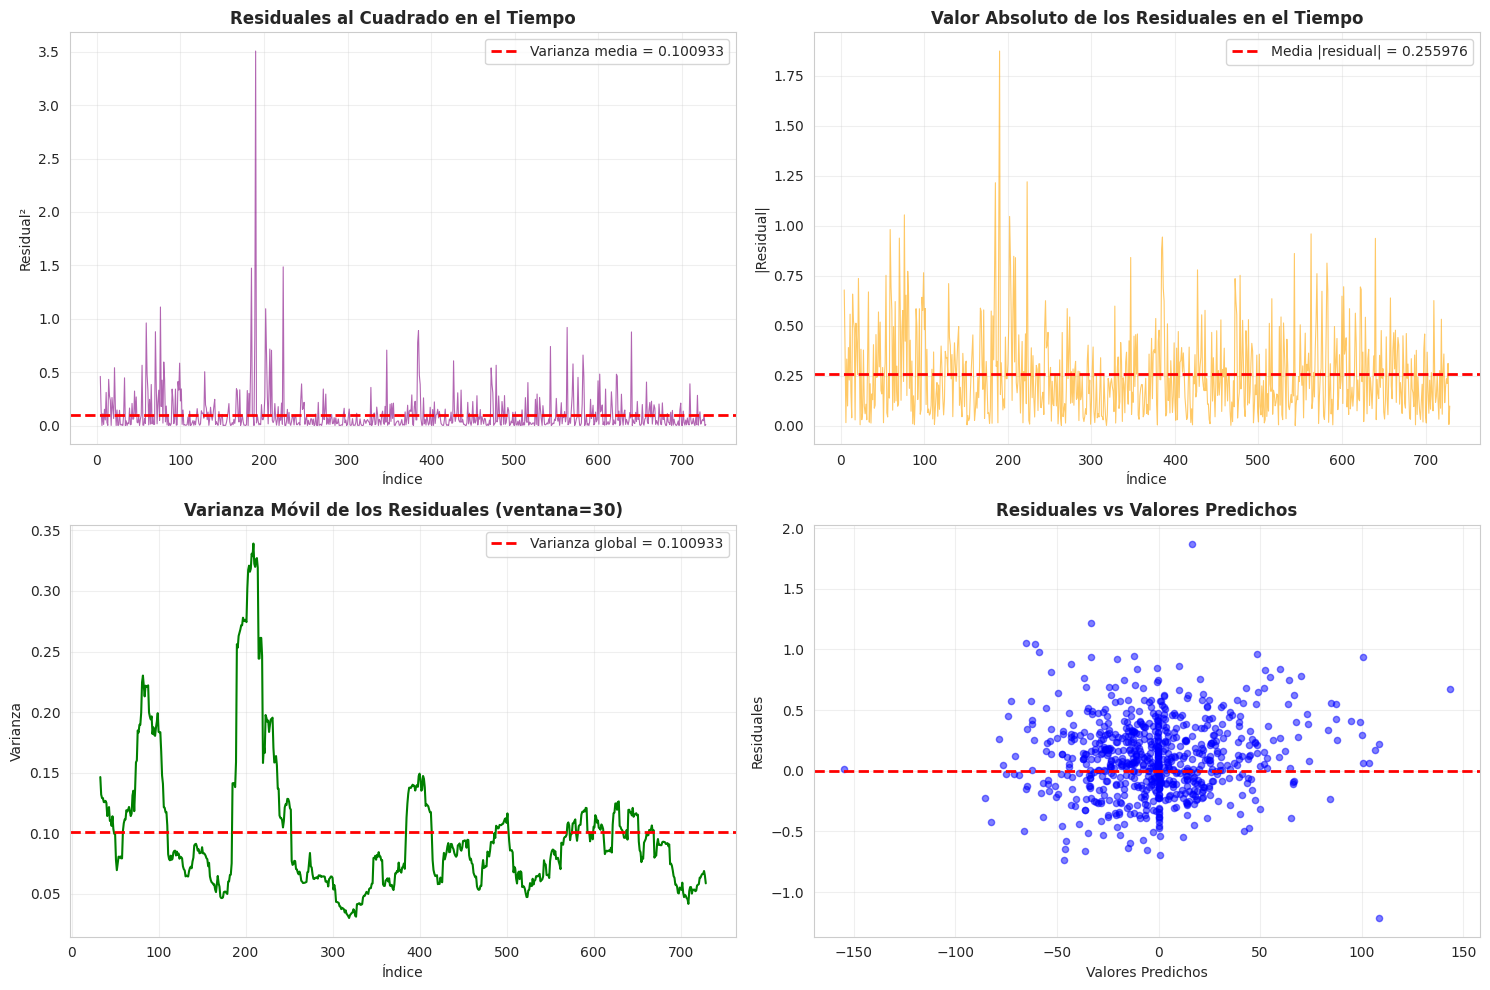


Interpretación visual:
- Si la varianza es constante (homocedasticidad), los residuales² y |residuales| deben distribuirse uniformemente
- La varianza móvil debe mantenerse estable alrededor de la varianza global
- En el scatter, los residuales deben distribuirse aleatoriamente sin formar patrones


In [95]:
# Visualización de varianza en el tiempo (para detectar heterocedasticidad visualmente)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Residuales al cuadrado en el tiempo
axes[0, 0].plot(residuals.index, residuals**2, color='purple', alpha=0.6, linewidth=0.8)
axes[0, 0].axhline(y=variance_residuals, color='red', linestyle='--', linewidth=2, label=f'Varianza media = {variance_residuals:.6f}')
axes[0, 0].set_title('Residuales al Cuadrado en el Tiempo', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Índice')
axes[0, 0].set_ylabel('Residual²')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Residuales absolutos en el tiempo
axes[0, 1].plot(residuals.index, np.abs(residuals), color='orange', alpha=0.6, linewidth=0.8)
axes[0, 1].axhline(y=np.abs(residuals).mean(), color='red', linestyle='--', linewidth=2, label=f'Media |residual| = {np.abs(residuals).mean():.6f}')
axes[0, 1].set_title('Valor Absoluto de los Residuales en el Tiempo', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Índice')
axes[0, 1].set_ylabel('|Residual|')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Rolling variance (ventana de 30)
window_size = min(30, len(residuals) // 3)
rolling_var = residuals.rolling(window=window_size).var()
axes[1, 0].plot(rolling_var.index, rolling_var, color='green', linewidth=1.5)
axes[1, 0].axhline(y=variance_residuals, color='red', linestyle='--', linewidth=2, label=f'Varianza global = {variance_residuals:.6f}')
axes[1, 0].set_title(f'Varianza Móvil de los Residuales (ventana={window_size})', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Índice')
axes[1, 0].set_ylabel('Varianza')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Scatter: Residuals vs Fitted values
axes[1, 1].scatter(y_pred.flatten(), residuals, alpha=0.5, s=20, color='blue')
axes[1, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_title('Residuales vs Valores Predichos', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Valores Predichos')
axes[1, 1].set_ylabel('Residuales')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nInterpretación visual:")
print("- Si la varianza es constante (homocedasticidad), los residuales² y |residuales| deben distribuirse uniformemente")
print("- La varianza móvil debe mantenerse estable alrededor de la varianza global")
print("- En el scatter, los residuales deben distribuirse aleatoriamente sin formar patrones")

### 5. Intervalos de Confianza de los Residuales

In [96]:
# 5. INTERVALOS DE CONFIANZA
# Lo ideal es que los residuales queden entre las bandas calculadas con el valor esperado 
# de la varianza del residual

print("=" * 70)
print("5. INTERVALOS DE CONFIANZA DE LOS RESIDUALES")
print("=" * 70)

# Calcular intervalos de confianza (95% y 99%)
confidence_levels = [0.95, 0.99]
std_res = residuals.std()
mean_res = residuals.mean()

print(f"\nMedia de los residuales: {mean_res:.6f}")
print(f"Desviación estándar: {std_res:.6f}")
print(f"Varianza: {variance_residuals:.6f}\n")

for conf_level in confidence_levels:
    # Usar distribución normal
    z_score = stats.norm.ppf((1 + conf_level) / 2)
    margin = z_score * std_res
    lower_bound = mean_res - margin
    upper_bound = mean_res + margin
    
    # Contar cuántos residuales están dentro del intervalo
    within_interval = ((residuals >= lower_bound) & (residuals <= upper_bound)).sum()
    percentage = (within_interval / len(residuals)) * 100
    
    print(f"--- Intervalo de Confianza del {conf_level*100:.0f}% ---")
    print(f"Límite inferior: {lower_bound:.6f}")
    print(f"Límite superior: {upper_bound:.6f}")
    print(f"Residuales dentro del intervalo: {within_interval}/{len(residuals)} ({percentage:.2f}%)")
    
    expected_percentage = conf_level * 100
    if percentage >= expected_percentage - 5:  # Tolerancia de 5%
        print(f"✓ CUMPLE: ~{percentage:.1f}% está dentro del intervalo (esperado: {expected_percentage:.0f}%)")
    else:
        print(f"✗ NO CUMPLE: Solo {percentage:.1f}% está dentro del intervalo (esperado: {expected_percentage:.0f}%)")
    print()

print("=" * 70)

5. INTERVALOS DE CONFIANZA DE LOS RESIDUALES

Media de los residuales: 0.106673
Desviación estándar: 0.317700
Varianza: 0.100933

--- Intervalo de Confianza del 95% ---
Límite inferior: -0.516007
Límite superior: 0.729354
Residuales dentro del intervalo: 687/726 (94.63%)
✓ CUMPLE: ~94.6% está dentro del intervalo (esperado: 95%)

--- Intervalo de Confianza del 99% ---
Límite inferior: -0.711668
Límite superior: 0.925015
Residuales dentro del intervalo: 715/726 (98.48%)
✓ CUMPLE: ~98.5% está dentro del intervalo (esperado: 99%)



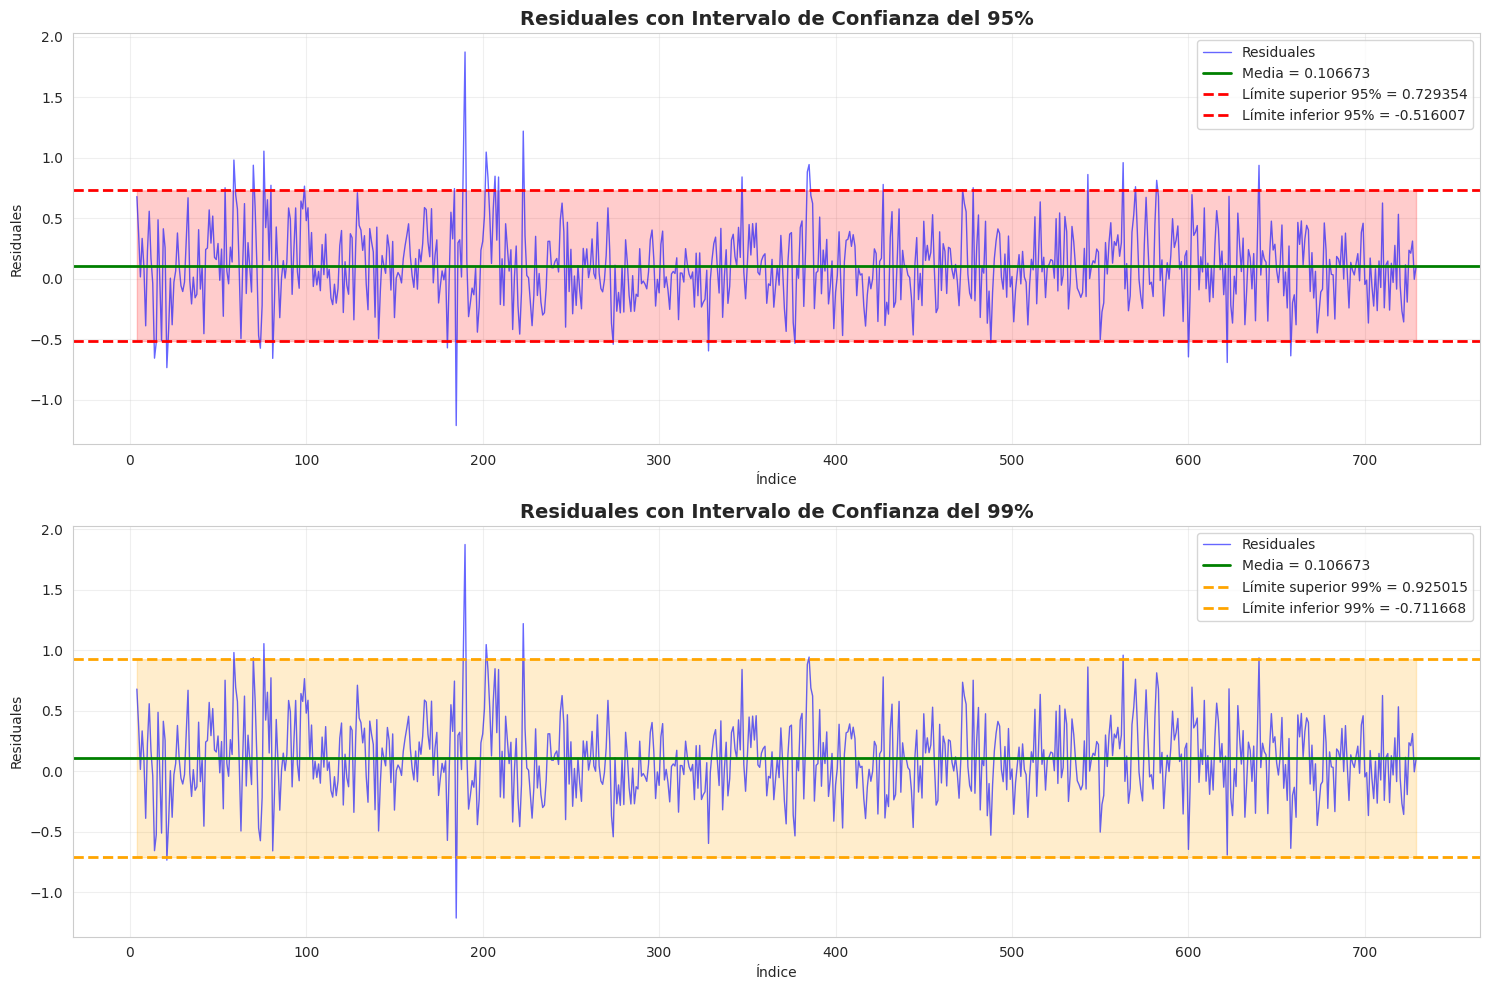


Outliers detectados (fuera del IC 99%): 11/726 (1.52%)
Índices de outliers: [21, 59, 70, 76, 185, 190, 202, 223, 385, 563]...


In [97]:
# Visualización de los residuales con intervalos de confianza
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Gráfico 1: Residuales con bandas de confianza del 95%
z_95 = stats.norm.ppf(0.975)  # 95% CI
upper_95 = mean_res + z_95 * std_res
lower_95 = mean_res - z_95 * std_res

axes[0].plot(residuals.index, residuals, color='blue', alpha=0.6, linewidth=1, label='Residuales')
axes[0].axhline(y=mean_res, color='green', linestyle='-', linewidth=2, label=f'Media = {mean_res:.6f}')
axes[0].axhline(y=upper_95, color='red', linestyle='--', linewidth=2, label=f'Límite superior 95% = {upper_95:.6f}')
axes[0].axhline(y=lower_95, color='red', linestyle='--', linewidth=2, label=f'Límite inferior 95% = {lower_95:.6f}')
axes[0].fill_between(residuals.index, lower_95, upper_95, alpha=0.2, color='red')
axes[0].set_title('Residuales con Intervalo de Confianza del 95%', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Índice')
axes[0].set_ylabel('Residuales')
axes[0].legend(loc='best')
axes[0].grid(True, alpha=0.3)

# Gráfico 2: Residuales con bandas de confianza del 99%
z_99 = stats.norm.ppf(0.995)  # 99% CI
upper_99 = mean_res + z_99 * std_res
lower_99 = mean_res - z_99 * std_res

axes[1].plot(residuals.index, residuals, color='blue', alpha=0.6, linewidth=1, label='Residuales')
axes[1].axhline(y=mean_res, color='green', linestyle='-', linewidth=2, label=f'Media = {mean_res:.6f}')
axes[1].axhline(y=upper_99, color='orange', linestyle='--', linewidth=2, label=f'Límite superior 99% = {upper_99:.6f}')
axes[1].axhline(y=lower_99, color='orange', linestyle='--', linewidth=2, label=f'Límite inferior 99% = {lower_99:.6f}')
axes[1].fill_between(residuals.index, lower_99, upper_99, alpha=0.2, color='orange')
axes[1].set_title('Residuales con Intervalo de Confianza del 99%', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Índice')
axes[1].set_ylabel('Residuales')
axes[1].legend(loc='best')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Identificar outliers (fuera del 99% CI)
outliers = residuals[(residuals < lower_99) | (residuals > upper_99)]
print(f"\nOutliers detectados (fuera del IC 99%): {len(outliers)}/{len(residuals)} ({len(outliers)/len(residuals)*100:.2f}%)")
if len(outliers) > 0:
    print(f"Índices de outliers: {list(outliers.index[:10])}{'...' if len(outliers) > 10 else ''}")

### 6. Resumen del Análisis de Residuales

In [98]:
# RESUMEN FINAL DEL ANÁLISIS DE RESIDUALES
print("\n" + "=" * 80)
print(" " * 20 + "RESUMEN DEL ANÁLISIS DE RESIDUALES")
print("=" * 80)

print("\n📊 RESULTADOS DE LAS PRUEBAS ESTADÍSTICAS:\n")

# 1. Valor esperado cero
print("1️⃣  VALOR ESPERADO CERO:")
print(f"   Media de los residuales: {mean_residuals:.6f}")
if abs(mean_residuals) < 0.01:
    print("   ✓ CUMPLE - La media está muy cercana a 0")
elif abs(mean_residuals) < 0.1:
    print("   ⚠ ACEPTABLE - La media está relativamente cerca de 0")
else:
    print("   ✗ NO CUMPLE - La media se aleja significativamente de 0")

# 2. No autocorrelación
print("\n2️⃣  NO AUTOCORRELACIÓN:")
max_lag = min(15, len(residuals) - 1)
autocorr_values = [residuals.iloc[lag:].corr(residuals.iloc[:-lag]) for lag in range(1, max_lag + 1)]
problematic_lags = sum(1 for corr in autocorr_values if abs(corr) >= 0.3)
print(f"   Lags problemáticos (|corr| >= 0.3): {problematic_lags}/{max_lag}")
if problematic_lags == 0:
    print("   ✓ CUMPLE - No hay autocorrelación significativa")
elif problematic_lags <= max_lag * 0.2:
    print("   ⚠ ACEPTABLE - Autocorrelación baja detectada")
else:
    print("   ✗ NO CUMPLE - Alta autocorrelación detectada")

# 3. Independencia
print("\n3️⃣  ALEATORIEDAD E INDEPENDENCIA:")
corr_res_yt = residuals.corr(y)
high_corr_X = sum(1 for col in X.columns if abs(residuals.corr(X[col])) >= 0.3)
print(f"   Correlación residuales-Y_t: {corr_res_yt:.4f}")
print(f"   Variables X con alta correlación: {high_corr_X}/{len(X.columns)}")
if abs(corr_res_yt) < 0.3 and high_corr_X == 0:
    print("   ✓ CUMPLE - Los residuales son independientes")
else:
    print("   ✗ NO CUMPLE - Existe dependencia con variables")

# 4. Normalidad
print("\n4️⃣  NORMALIDAD (Test de Shapiro-Wilk):")
shapiro_stat, shapiro_p = stats.shapiro(residuals)
print(f"   P-value: {shapiro_p:.6f}")
if shapiro_p > 0.05:
    print("   ✓ CUMPLE - Los residuales siguen distribución normal")
else:
    print("   ⚠ NO CUMPLE - Pero es aceptable (la normalidad es difícil de lograr)")

# 5. Homocedasticidad (usando ARCH con lag 1)
print("\n5️⃣  HOMOCEDASTICIDAD (Test ARCH):")
try:
    lm_stat, lm_pvalue, f_stat, f_pvalue = het_arch(residuals, nlags=1)
    print(f"   P-value (Lag 1): {lm_pvalue:.6f}")
    if lm_pvalue > 0.05:
        print("   ✓ CUMPLE - Varianza constante (homocedasticidad)")
    else:
        print("   ✗ NO CUMPLE - Existe heterocedasticidad")
except Exception as e:
    print(f"   ⚠ Error al calcular: {e}")

# 6. Intervalos de confianza
print("\n6️⃣  INTERVALOS DE CONFIANZA (95%):")
z_95 = stats.norm.ppf(0.975)
within_95 = ((residuals >= mean_res - z_95*std_res) & (residuals <= mean_res + z_95*std_res)).sum()
percentage_95 = (within_95 / len(residuals)) * 100
print(f"   Residuales dentro del IC 95%: {percentage_95:.2f}% (esperado: 95%)")
if percentage_95 >= 90:
    print("   ✓ CUMPLE - Los residuales están dentro del intervalo esperado")
else:
    print("   ✗ NO CUMPLE - Muchos residuales fuera del intervalo")

# Conclusión general
print("\n" + "=" * 80)
print("📝 CONCLUSIÓN GENERAL:")
print("=" * 80)

conditions_met = 0
total_conditions = 4  # Condiciones críticas: 1, 2, 3, 4

if abs(mean_residuals) < 0.1:
    conditions_met += 1
if problematic_lags <= max_lag * 0.2:
    conditions_met += 1
if abs(corr_res_yt) < 0.3 and high_corr_X == 0:
    conditions_met += 1
if lm_pvalue > 0.05:
    conditions_met += 1

print(f"\nCondiciones críticas cumplidas: {conditions_met}/{total_conditions}\n")

if conditions_met == total_conditions:
    print("✓✓✓ EXCELENTE: El modelo ha capturado correctamente la estructura de la serie.")
    print("    Los residuales se comportan como ruido blanco.")
elif conditions_met >= total_conditions * 0.75:
    print("✓✓ BUENO: El modelo captura la mayor parte de la estructura de la serie.")
    print("   Hay margen de mejora pero el modelo es aceptable.")
elif conditions_met >= total_conditions * 0.5:
    print("⚠ REGULAR: El modelo captura parcialmente la estructura de la serie.")
    print("  Se recomienda revisar la arquitectura o agregar más variables.")
else:
    print("✗ DEFICIENTE: El modelo NO ha capturado adecuadamente la estructura.")
    print("  Se requieren modificaciones significativas o un modelo más complejo.")

print("\n" + "=" * 80)


                    RESUMEN DEL ANÁLISIS DE RESIDUALES

📊 RESULTADOS DE LAS PRUEBAS ESTADÍSTICAS:

1️⃣  VALOR ESPERADO CERO:
   Media de los residuales: 0.106673
   ✗ NO CUMPLE - La media se aleja significativamente de 0

2️⃣  NO AUTOCORRELACIÓN:
   Lags problemáticos (|corr| >= 0.3): 15/15
   ✗ NO CUMPLE - Alta autocorrelación detectada

3️⃣  ALEATORIEDAD E INDEPENDENCIA:
   Correlación residuales-Y_t: 0.0957
   Variables X con alta correlación: 2/6
   ✗ NO CUMPLE - Existe dependencia con variables

4️⃣  NORMALIDAD (Test de Shapiro-Wilk):
   P-value: 0.000003
   ⚠ NO CUMPLE - Pero es aceptable (la normalidad es difícil de lograr)

5️⃣  HOMOCEDASTICIDAD (Test ARCH):
   P-value (Lag 1): 0.000004
   ✗ NO CUMPLE - Existe heterocedasticidad

6️⃣  INTERVALOS DE CONFIANZA (95%):
   Residuales dentro del IC 95%: 94.63% (esperado: 95%)
   ✓ CUMPLE - Los residuales están dentro del intervalo esperado

📝 CONCLUSIÓN GENERAL:

Condiciones críticas cumplidas: 0/4

✗ DEFICIENTE: El modelo NO ha cap